# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
# Импортируем библиотеки
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions_history=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv') 

In [3]:
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
unique_sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique()
unique_sessions_per_user 

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64

In [5]:
user_id_with_most_sessions = unique_sessions_per_user.idxmax()

In [6]:
user_data = sessions_history[sessions_history['user_id'] == user_id_with_most_sessions]
user_data

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Сформировали таблицу по пользователю у которого наибольшее колличество сессий. В солбцах предствалена информация по каждому дню. У каждой сессии свой  идентификационный номер. У данного пользователя было 10 сессий, в толбце `session_number` указан порядковый номер. Так же по таблице можно посмотреть регион пользователя и с какого устройства он заходил в приложение.	

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [7]:
# Рассчитаем число уникальных пользователей по дня
unic_users=sessions_history.groupby('session_date')['user_id'].nunique() 

In [8]:
# Отфильтруем зарегистрированных пользователей
registered_users = sessions_history[sessions_history['registration_flag'] == 1]

In [9]:
#  Рассчитаем число зарегистрированных пользователей по дням
unic_users_regist = registered_users.groupby('session_date')['user_id'].nunique()

Для построения графика обьединим 2 таблицы с общим колличеством пользователей и колличеством зарегистрированных пользователей по столбцу `session_date`. Также для удобства переименуем столбцы с количеством пользователей, для всех пользователей добавим суффикс `_total`, для зарегистрированных - `_regist`

In [10]:
user_data = pd.merge(unic_users, unic_users_regist, on='session_date', how='left',suffixes=('_total','_regist'))

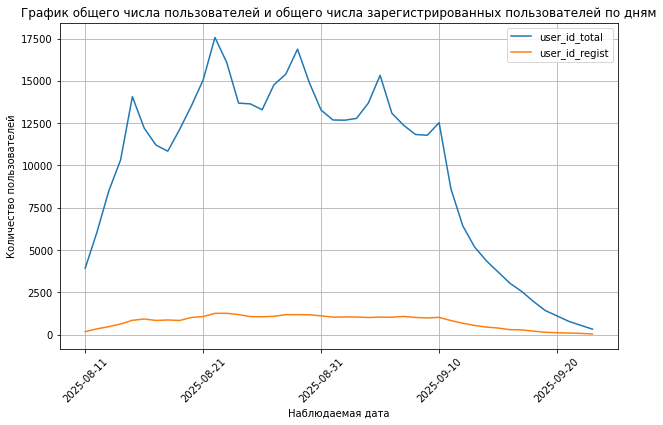

In [11]:
# Строим линейный график
user_data.plot.line(rot=45, figsize=(10, 6))

# Настраиваем оси
plt.title('График общего числа пользователей и общего числа зарегистрированных пользователей по дням')
plt.xlabel('Наблюдаемая дата')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()

Рассмотрим более подробно распределение количества пользователей по дням. Построим с помощью subplots 2 графика, где каждый столбец датафрейма визуализируется на отдельном графике.

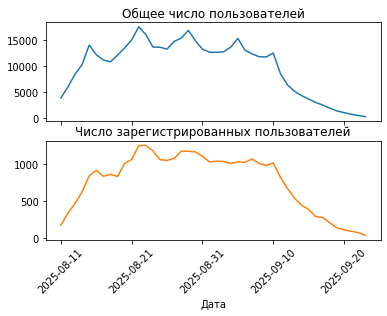

In [12]:
# Строим линейный график
user_data.plot(kind='line',rot=45,
            subplots=True,
            sharex=True,
            sharey=False,
            legend=False,
            title=['Общее число пользователей', 'Число зарегистрированных пользователей'])

# Подписываем оси
plt.xlabel('Дата')
plt.show()

На основании 2 графиков видим, что общее количество пользователей больше,чем колличество зарегистрированных. По дням они распределены примерно одинаково.

Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [13]:
# рассчитаем долю зарегистрированных пользователей
registered_ratio = unic_users_regist/unic_users

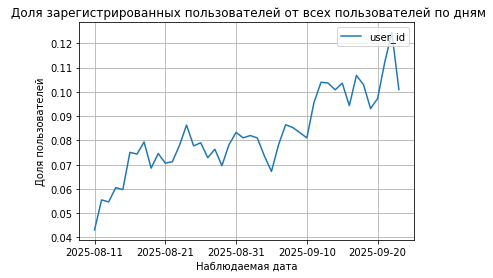

In [14]:
registered_ratio.plot(
    kind='line',
    x='session_date',
     title='Доля зарегистрированных пользователей от всех пользователей по дням'
)

# Настраиваем оси
plt.title(' Доля зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('Наблюдаемая дата')
plt.ylabel('Доля пользователей')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()

По графику видно,что доля зарегистрированных имеет положительную динамику и увеличивается с каждым днем в наблюдаемом периоде.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [15]:
# количество сессий для каждого значения количества просмотренных страниц
number_of_pages = sessions_history.groupby('page_counter').agg({'session_id' : 'count'})
number_of_pages

,session_id
page_counter,
1,29160
2,105536
3,166690
4,105569
5,26288
6,2589
7,92


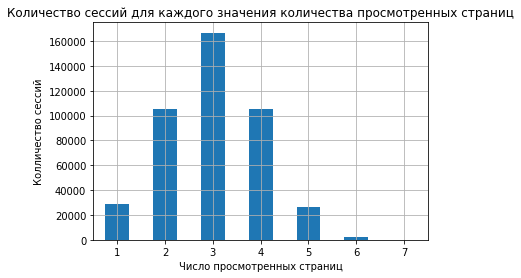

In [16]:
number_of_pages.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0,
               legend=False, # Выключаем легенду
               title=f'Количество сессий для каждого значения количества просмотренных страниц'
)

# Настраиваем оформление графика
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Колличество сессий')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

**Вывод:** Из графика видно, что в среднем большинство пользователей просматривает от 2 (105536 сесий) до 4 страниц (105569сессий). Больше всего - 3 страницы - 166690 сессий.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

Создадим дополнительный столбец `good_session`. В него войдёт значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если было просмотрено меньше.

In [17]:
def sessions (session):
    if session['page_counter']>= 4:
        return 1
    else:
        return 0

sessions_history['good_session'] = sessions_history.apply(sessions, axis=1)

Проверим результат добавления столбца `good_session`

In [18]:
#Выведем первые строки
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


Отфильтруем данные по столбцу `good_session=1`,т.е если за одну сессию было просмотрено 4 и более страниц.

In [19]:
good_session = sessions_history.loc[(sessions_history['good_session']== 1)]

Посчитаем количество успешных сессий для каждого дня

In [20]:
good_session_group=good_session.groupby('session_date')['session_id'].count()

Посчитаем общее колличество сессий для каждого дня

In [21]:
total_session=sessions_history.groupby('session_date')['session_id'].count()

Посчитаем доли успешных сессий ко всем сессиям по дням за весь период наблюдения и построим график со средним значением доли успешных сессий ко всем сессиям

In [22]:
percentage_of_sessions=good_session_group/total_session
percentage_of_sessions.sort_values(ascending=False)

session_date
2025-09-17    0.320251
2025-09-19    0.318054
2025-08-17    0.317589
2025-08-14    0.316055
2025-09-04    0.315501
2025-09-02    0.315499
2025-08-30    0.313814
2025-08-22    0.313158
2025-08-29    0.313104
2025-08-19    0.312840
2025-08-11    0.312835
2025-09-01    0.312495
2025-09-07    0.312121
2025-09-16    0.312005
2025-08-27    0.311120
2025-08-26    0.310934
2025-08-28    0.310567
2025-08-18    0.310545
2025-08-24    0.309800
2025-09-22    0.309524
2025-09-08    0.308811
2025-09-14    0.307745
2025-08-20    0.306941
2025-08-13    0.306750
2025-08-16    0.306186
2025-09-15    0.305841
2025-09-09    0.305518
2025-08-25    0.305464
2025-09-10    0.305125
2025-08-15    0.304941
2025-09-11    0.304650
2025-09-06    0.304557
2025-09-03    0.304140
2025-09-05    0.303837
2025-08-21    0.303169
2025-08-31    0.302503
2025-08-23    0.302077
2025-08-12    0.302015
2025-09-20    0.301818
2025-09-12    0.301585
2025-09-13    0.299055
2025-09-18    0.292520
2025-09-23    0.29022

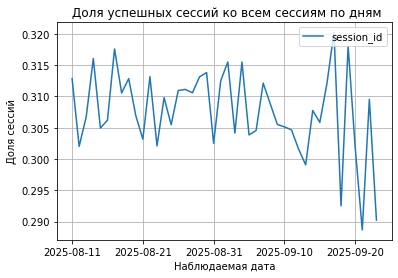

In [23]:
percentage_of_sessions.plot(
    kind='line',
    x='session_date',
     title='Доля зарегистрированных пользователей от всех пользователей по дням'
)

# Настраиваем оси
plt.title(' Доля успешных сессий ко всем сессиям по дням')
plt.xlabel('Наблюдаемая дата')
plt.ylabel('Доля сессий')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()

**Вывод:** Самая большая доля зарегистрированных пользователей была 2025-09-17, самая маленькая доля была 2025-09-21. Ближе к концу сентября доля зарегистрированных пользоватей сильно колеблется, по сравнению с августом и началом сентября.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [24]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [25]:
from math import ceil
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users =(sessions_history.groupby('session_date')['user_id'].nunique()).mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((17441 * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [26]:
sessions_test_part=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv') 

In [27]:
#выведем первые строки
sessions_test_part.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


Посчитаем количество уникальные пользователей в группе А

In [28]:
sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique().shape[0]

1477

Посчитаем количество уникальные пользователей в группе В

In [29]:
sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique().shape[0]

1466

In [30]:
p_a=100 * sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() / sessions_test_part['user_id'].nunique()
p_a

50.18688413183826

In [31]:
p_b=100 * sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique() / sessions_test_part['user_id'].nunique()
p_b

49.81311586816174

<Figure size 504x216 with 0 Axes>

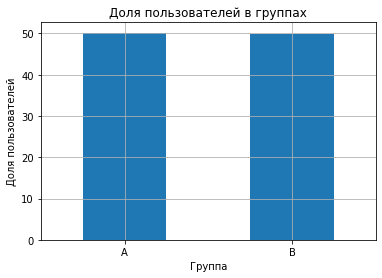

In [32]:
data = {'test_group': ['A', 'B'],
        'user': [p_a, p_b]} 
df = pd.DataFrame(data,index=['A', 'B'])

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Доля пользователей в группах'
)

# Настраиваем оформление графика
plt.xlabel('Группа')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Расхождение стало более наглядным — оно небольшое, и им можно пренебречь.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [33]:
group_a= sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
group_b= sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(group_a) & set(group_b))
print(intersection) 

[]


В группах нет пользователей, которые встречаються одновременно в группе А и группе В

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [34]:
# Oтфильтруем таблицу по группе А
filtr_group_a= sessions_test_part.loc[(sessions_test_part['test_group'] == 'A')]

In [35]:
# Уберем дубликаты по столбцу user_id
non_duplic_user_a = filtr_group_a[~filtr_group_a['user_id'].duplicated(keep=False)]

In [36]:
# Рассчитаем долю каждого типа устройства
non_duplic_user_a['device'].value_counts(normalize=True)

Android    0.446259
PC         0.248980
iPhone     0.199320
Mac        0.105442
Name: device, dtype: float64

Для визуального анализа такого распределения можно использовать столбчатые диаграммы. Визуализируем распределение в столбце `device` для группы А:

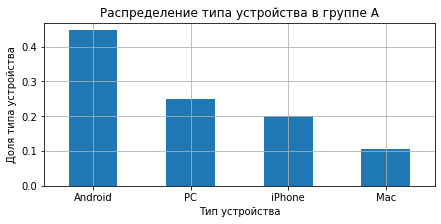

In [37]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
non_duplic_user_a['device'].value_counts(normalize=True).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение типа устройства в группе А'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Доля типа устройства')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [38]:
# Oтфильтруем таблицу по группе В
filtr_group_b= sessions_test_part.loc[(sessions_test_part['test_group'] == 'B')]

In [39]:
# Уберем дубликаты по столбцу user_id
non_duplic_user_b = filtr_group_b[~filtr_group_b['user_id'].duplicated(keep=False)]

In [40]:
# Рассчитаем долю каждого типа устройства
non_duplic_user_b['device'].value_counts(normalize=True)

Android    0.459097
PC         0.264457
iPhone     0.181946
Mac        0.094499
Name: device, dtype: float64

Визуализируем распределение в столбце `device` для группы B:

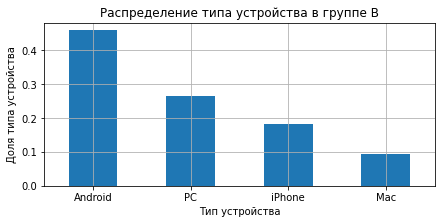

In [41]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
non_duplic_user_b['device'].value_counts(normalize=True).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение типа устройства в группе В'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Доля типа устройства')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

**Вывод:** В обоих группах распределение по типу устройства совпадает. Большинство пользователей используют Android (в группе А - 0.446259, в группе В - 0.459097), далее по популярности PC (в группе А -  0.248980, в группе В-0.264457), iPhone (в группе А-0.105442,в группе В - 0.204394) и Mac (в группе А - 0.121007, группе В - 0.094499).

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [42]:
# Рассчитаем долю для каждого региона в группе А
non_duplic_user_a['region'].value_counts(normalize=True)

CIS     0.436054
MENA    0.412925
EU      0.151020
Name: region, dtype: float64

Визуализируем распределение в столбце `region` для группы А:

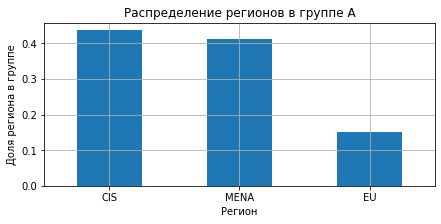

In [43]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
non_duplic_user_a['region'].value_counts(normalize=True).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение регионов в группе А'
)

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля региона в группе')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [44]:
# Рассчитаем долю для каждого региона в группе В
non_duplic_user_b['region'].value_counts(normalize=True)

CIS     0.454866
MENA    0.392807
EU      0.152327
Name: region, dtype: float64

Визуализируем распределение в столбце `region` для группы А:

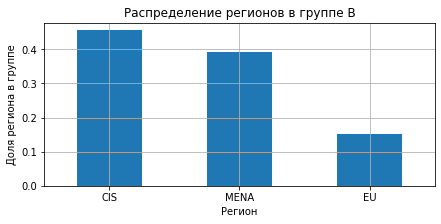

In [45]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
non_duplic_user_b['region'].value_counts(normalize=True).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение регионов в группе B'
)

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля региона в группе')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

**Вывод:** Распределение в группах совпадает. В группе А больше всего пользователей в регионе CIS - 0.4360541, далее в регионе MENA- 0.412925 и в регионе EU - 0.151020, и в группе B в регионе CIS - 0.454866, MENA-0.39280,EU - 0.152327. 

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

1. Различие в количестве пользователей в группах:

Наблюдается незначительное расхождение в количестве пользователей между группами A и B. Данное расхождение невелико и, вероятно, им можно пренебречь, не оказывая существенного влияния на результаты A/B-теста. Отношении долей к общему количетву пользователей: В группе А - 50,19, в группе В - 49,81.

2. Независимость выборок и пересечение пользователей:

Выборки являются независимыми. Не было обнаружено пользователей, одновременно участвующих в группе A и группе B. Это подтверждает корректность формирования тестовой и контрольной групп. Число таких пересечений равно 0.

3. Равномерное распределение по категориальным переменным:

Устройства:
В обоих группах распределение по типу устройства совпадает. Большинство пользователей используют Android (в группе А - 0.446259, в группе В - 0.459097), далее по популярности PC (в группе А - 0.248980, в группе В-0.264457), iPhone (в группе А-0.105442,в группе В - 0.204394) и Mac (в группе А - 0.121007, группе В - 0.094499).

Регионы:
Распределение в группах совпадает. В группе А больше всего пользователей в регионе CIS - 0.4360541, далее в регионе MENA- 0.412925 и в регионе EU - 0.151020, и в группе B в регионе CIS - 0.454866, MENA-0.39280, EU - 0.152327. 

4. Заключение о корректности A/B-теста:

A/B-тест проходит корректно. Соблюдены основные требования к проведению A/B-тестов: 

 - Размер выборки достаточен (необходимый размер выборки составлял 17441 пользователей для каждой группы, а фактический размер выборки ему соответствовал). 
- Длительность теста определена на основе трафика приложения (4 дня при среднем трафике 9907 пользователей в день). 
- Группы сформированы независимо и не содержат пересекающихся пользователей. 
- Равномерность распределения пользователей по основным категориальным переменным (устройства и регионы) соблюдена. Несмотря на небольшие расхождения в количестве пользователей и распределении по регионам, они не являются критичными и не должны существенно повлиять на результаты теста. 

На основании имеющихся данных, можно сделать вывод о том, что A/B-тест проводится в соответствии с необходимыми требованиями и результаты можно считать валидными.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [46]:
sessions_test=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv') 

В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если просмотрено меньше.

In [47]:
def sessions_good (session):
    if session['page_counter']>= 4:
        return 1
    else:
        return 0

sessions_test['good_session'] = sessions_test.apply(sessions_good, axis=1)

Проверим добавление столбца `good_session` в датафрейм:

In [48]:
# Выведем первые 5 строк датафрейма
sessions_test.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

In [49]:
# Отфильтруем данные по группе A
unic_session_a=sessions_test[sessions_test['test_group'] == 'A']

In [50]:
# Рассчитаем колличество уникальных сессий в группе А по дням
unic_session_group_a=unic_session_a.groupby('session_date')['session_id'].count()
unic_session_group_a

session_date
2025-10-14    1502
2025-10-15    2235
2025-10-16    3280
2025-10-17    4089
2025-10-18    5013
2025-10-19    6535
2025-10-20    5837
2025-10-21    3927
2025-10-22    3083
2025-10-23    2470
2025-10-24    2090
2025-10-25    1897
2025-10-26    1669
2025-10-27    1454
2025-10-28    1279
2025-10-29    1068
2025-10-30     887
2025-10-31     644
2025-11-01     434
2025-11-02     158
Name: session_id, dtype: int64

In [51]:
# Отфильтруем данные по группе B
unic_session_b=sessions_test[sessions_test['test_group'] == 'B']

In [52]:
# Рассчитаем колличество уникальных сессий в группе B по дням
unic_session_group_b=unic_session_b.groupby('session_date')['session_id'].count()
unic_session_group_b

session_date
2025-10-14    1628
2025-10-15    2283
2025-10-16    3241
2025-10-17    4054
2025-10-18    5059
2025-10-19    6779
2025-10-20    6089
2025-10-21    3981
2025-10-22    3111
2025-10-23    2548
2025-10-24    2068
2025-10-25    1814
2025-10-26    1692
2025-10-27    1517
2025-10-28    1289
2025-10-29    1131
2025-10-30     876
2025-10-31     669
2025-11-01     465
2025-11-02     160
Name: session_id, dtype: int64

In [53]:
metric_a=unic_session_a.groupby('session_date')['session_id'].count()
metric_b=unic_session_b.groupby('session_date')['session_id'].count()
alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='two-sided')

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение. Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения. Выборочные средние в группах A и B не равны')
    

p-value теста Стьюдента =0.94
Нулевая гипотеза находит подтверждение. Выборочные средние в группах A и B равны


**Вывод:** Полученное значение p-value, равное 0.94, значительно превышает общепринятый уровень значимости (alpha 0.05). Это означает, что у нас нет достаточных оснований отвергнуть нулевую гипотезу.

Мы не обнаружили статистически значимых различий между выборочными средними в группах A и B. Вероятность получить наблюдаемые (или более экстремальные) различия между средними, если на самом деле между ними нет никакой разницы (то есть нулевая гипотеза верна), составляет 94%.

Поэтому мы принимаем нулевую гипотезу: нет достаточных оснований полагать, что средние значения в группах A и B различны.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [54]:
# Рассчитываем общее количество сессий для каждой группы
total_sessions_a = len(sessions_test[sessions_test['test_group'] == 'A'])
total_sessions_b = len(sessions_test[sessions_test['test_group'] == 'B'])
print(f"Общее количество сессий в группе A: {total_sessions_a}")
print(f"Общее количество сессий в группе В: {total_sessions_b}")

Общее количество сессий в группе A: 49551
Общее количество сессий в группе В: 50454


In [55]:
# Рассчитываем количество успешных сессий для каждой группы
good_sessions_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
good_sessions_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
print(f"Общее количество успешных сессий в группе A: {good_sessions_a}")
print(f"Общее количество успешных сессий в группе В: {good_sessions_b}")

Общее количество успешных сессий в группе A: 15248
Общее количество успешных сессий в группе В: 16059


In [56]:
# Рассчитываем долю успешных сессий для каждой группы
good_session_rate_a = good_sessions_a / total_sessions_a
good_session_rate_b = good_sessions_b / total_sessions_b
print(f"Доля успешных сессий в группе A: {good_session_rate_a}")
print(f"Доля успешных сессий в группе В: {good_session_rate_b}")

Доля успешных сессий в группе A: 0.3077233557344958
Доля успешных сессий в группе В: 0.31828992745867524


In [57]:
# Рассчитываем разницу в долях
rate_difference = good_session_rate_b - good_session_rate_a
print(f"Разница в долях (В-A): {rate_difference}")

Разница в долях (В-A): 0.010566571724179463


**Вывод:** количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Применим Z-тест пропорций:

In [58]:
if (good_session_rate_a*total_sessions_a > 10)and((1-good_session_rate_a)*total_sessions_a > 10) and (good_session_rate_b*total_sessions_b > 10)and((1-good_session_rate_b)*total_sessions_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [good_sessions_a, good_sessions_b],
    [total_sessions_a, total_sessions_b],
    alternative='smaller' 
)

print(f'pvalue={p_value_ztest}') # выведите полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение')
else:
    print('Нулевая гипотеза не находит подтверждения')

text_interpretation = 'не изменилось' # напишите одно из выражений ("сократилось", "не изменилось", "увеличилось")

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.0001574739988036123
Нулевая гипотеза не находит подтверждения


**Вывод:** Полученное значение p-value, равное 0.00016 (округлённо), чрезвычайно мало и значительно меньше общепринятого уровня значимости (alpha), например, 0.05. Это означает, что у нас есть убедительные основания отвергнуть нулевую гипотезу.

В контексте A/B-теста, это говорит о том, что мы обнаружили статистически значимое различие между метриками (например, долей успешных сессий) в группах A и B. Вероятность получить наблюдаемые (или более экстремальные) различия, если на самом деле между группами нет никакой разницы, крайне мала (около 0.016%).

Мы отвергаем нулевую гипотезу. Существуют статистически значимые доказательства того, что между метриками в группах A и B есть разница. Необходимо определить, какая группа показала лучшие результаты, чтобы принять решение о внедрении изменений.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

1. Характеристики эксперимента:

Тип эксперимента: A/B-тестирование нового алгоритма рекомендаций.
Ключевая метрика: Доля успешных сессий (good_session).
Размер выборок: 17441 пользователей для каждой группы
Длительность эксперимента: 4 дня

2. Влияние нового алгоритма рекомендаций на ключевую метрику:

В ходе эксперимента было обнаружено статистически значимое влияние нового алгоритма рекомендаций на долю успешных сессий пользователей. Наблюдается увеличение доли успешных сессий в группе В. Дальнейший анализ необходим для оценки величины эффекта и возможных побочных эффектов.

3. Значение p-value:

P-value для оценки статистической значимости разницы в долях успешных сессий между группами составило 0.00016. Данное значение значительно меньше установленного уровня значимости (alpha = 0.05), что свидетельствует о высокой статистической значимости полученного результата.

4. Рекомендации по внедрению нововведения:

Требуется дальнейший анализ, прежде чем принимать решение о внедрении нового алгоритма рекомендаций.
Рекомендуется проверить отсутствие негативных изменений в других важных метриках. При положительном результате анализа - рекомендуется внедрение нового алгоритма.